#### Imports

In [55]:
from kafka import KafkaProducer, KafkaConsumer
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import itertools
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import requests
import json
import os
from datetime import datetime

In [56]:
# Load environment variables from .env file
load_dotenv()

# Access the API key from the environment variable
api_key = os.getenv("API_KEY")

#### Testing cells

##### Fetching data from api and seeing response in json

In [57]:
params = {
  'access_key': api_key
}

api_result = requests.get('http://api.marketstack.com/v1/tickers/aapl/eod', params)

api_response = api_result.json()

In [18]:
api_response

{'pagination': {'limit': 100, 'offset': 0, 'count': 100, 'total': 251},
 'data': {'name': 'Apple Inc',
  'symbol': 'AAPL',
  'country': None,
  'has_intraday': False,
  'has_eod': True,
  'eod': [{'open': 189.98,
    'high': 190.05,
    'low': 187.4511,
    'close': 189.43,
    'volume': 43389519.0,
    'adj_high': 190.05,
    'adj_low': 187.4511,
    'adj_close': 189.43,
    'adj_open': 189.98,
    'adj_volume': 43389519.0,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'AAPL',
    'exchange': 'XNAS',
    'date': '2023-12-04T00:00:00+0000'},
   {'open': 190.33,
    'high': 191.56,
    'low': 189.23,
    'close': 191.24,
    'volume': 45679300.0,
    'adj_high': 191.56,
    'adj_low': 189.23,
    'adj_close': 191.24,
    'adj_open': 190.33,
    'adj_volume': 45704823.0,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'AAPL',
    'exchange': 'XNAS',
    'date': '2023-12-01T00:00:00+0000'},
   {'open': 189.84,
    'high': 190.32,
    'low': 188.19,
    'close': 1

In [19]:
api_result = requests.get('http://api.marketstack.com/v1/tickers/KNEBV.XHEL/eod', params)

api_response = api_result.json()

In [20]:
api_response

{'pagination': {'limit': 100, 'offset': 0, 'count': 100, 'total': 220},
 'data': {'name': 'KONE CORPORATION',
  'symbol': 'KNEBV',
  'has_intraday': False,
  'has_eod': True,
  'country': None,
  'eod': [{'open': 38.77,
    'high': 38.77,
    'low': 38.28,
    'close': 38.38,
    'volume': 531357.0,
    'adj_high': None,
    'adj_low': None,
    'adj_close': 38.38,
    'adj_open': None,
    'adj_volume': None,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'KNEBV.XHEL',
    'exchange': 'XHEL',
    'date': '2023-10-18T00:00:00+0000'},
   {'open': 39.04,
    'high': 39.14,
    'low': 38.5,
    'close': 38.79,
    'volume': 292560.0,
    'adj_high': None,
    'adj_low': None,
    'adj_close': 38.79,
    'adj_open': None,
    'adj_volume': None,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'KNEBV.XHEL',
    'exchange': 'XHEL',
    'date': '2023-10-17T00:00:00+0000'},
   {'open': 39.44,
    'high': 39.61,
    'low': 38.74,
    'close': 39.21,
    'volume': 433411

#### Functions

##### Function to fetch data from api

In [21]:
def fetch_data_from_api():
    # 
    params = {
        'access_key': api_key,
        'exchange': 'XNAS',
        'date_from': '2023-01-01',
        'limit': '1000'
    }
    
    response = requests.get('http://api.marketstack.com/v1/tickers/msft/eod', params)
    return response.json()

In [22]:
api_data = fetch_data_from_api()
api_data

{'pagination': {'limit': 1000, 'offset': 0, 'count': 232, 'total': 232},
 'data': {'name': 'Microsoft Corporation',
  'symbol': 'MSFT',
  'country': None,
  'has_intraday': False,
  'has_eod': True,
  'eod': [{'open': 369.1,
    'high': 369.52,
    'low': 362.9,
    'close': 369.14,
    'volume': 32063305.0,
    'adj_high': 369.52,
    'adj_low': 362.9,
    'adj_close': 369.14,
    'adj_open': 369.1,
    'adj_volume': 32063305.0,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'MSFT',
    'exchange': 'XNAS',
    'date': '2023-12-04T00:00:00+0000'},
   {'open': 376.76,
    'high': 378.16,
    'low': 371.31,
    'close': 374.51,
    'volume': 33020400.0,
    'adj_high': 378.16,
    'adj_low': 371.31,
    'adj_close': 374.51,
    'adj_open': 376.76,
    'adj_volume': 33040472.0,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'MSFT',
    'exchange': 'XNAS',
    'date': '2023-12-01T00:00:00+0000'},
   {'open': 378.49,
    'high': 380.09,
    'low': 375.47,
    'clos

##### Function to extract and format data from api response

In [23]:
# Function to select and extract data from api response
def extract_data_from_response(response_json):
    # List with end-of-day data
    eod_data = response_json.get('data', {}).get('eod', [])

    extracted_data = []
    for day_data in eod_data:
        # Parse and format date string
        parsed_date = datetime.strptime(day_data.get('date'), '%Y-%m-%dT%H:%M:%S%z')
        formatted_date = parsed_date.strftime('%Y-%m-%d')

        entry = {
            'open': float(day_data.get('open')),
            'high': float(day_data.get('high')),
            'low': float(day_data.get('low')),
            'close': float(day_data.get('close')),
            'volume': int(day_data.get('volume')),
            'symbol': day_data.get('symbol'),
            'exchange': day_data.get('exchange'),
            'date': formatted_date
        }
        extracted_data.append(entry)
    
    return extracted_data

In [24]:
selected_data = extract_data_from_response(api_data)
selected_data

[{'open': 369.1,
  'high': 369.52,
  'low': 362.9,
  'close': 369.14,
  'volume': 32063305,
  'symbol': 'MSFT',
  'exchange': 'XNAS',
  'date': '2023-12-04'},
 {'open': 376.76,
  'high': 378.16,
  'low': 371.31,
  'close': 374.51,
  'volume': 33020400,
  'symbol': 'MSFT',
  'exchange': 'XNAS',
  'date': '2023-12-01'},
 {'open': 378.49,
  'high': 380.09,
  'low': 375.47,
  'close': 378.91,
  'volume': 30531000,
  'symbol': 'MSFT',
  'exchange': 'XNAS',
  'date': '2023-11-30'},
 {'open': 383.76,
  'high': 384.3,
  'low': 377.44,
  'close': 378.85,
  'volume': 28942500,
  'symbol': 'MSFT',
  'exchange': 'XNAS',
  'date': '2023-11-29'},
 {'open': 378.35,
  'high': 383.0,
  'low': 378.16,
  'close': 382.7,
  'volume': 20429400,
  'symbol': 'MSFT',
  'exchange': 'XNAS',
  'date': '2023-11-28'},
 {'open': 376.78,
  'high': 380.64,
  'low': 376.2,
  'close': 378.61,
  'volume': 22152000,
  'symbol': 'MSFT',
  'exchange': 'XNAS',
  'date': '2023-11-27'},
 {'open': 377.33,
  'high': 377.97,
  'l

##### Function to produce to Kafka topic

In [29]:
# Function to produce data to Kafka
def produce_to_kafka(data):
    # Convert data to JSON string
    json_data = json.dumps(data)

    # Initialize Kafka producer 
    producer = KafkaProducer(
        bootstrap_servers='localhost:9092',
        value_serializer=lambda x: x.encode('utf-8'))

    # Send data from producer to topic
    producer.send('quickstart-events', value=json_data)
    producer.close()

In [31]:
produce_to_kafka(selected_data)

##### Function to consume from Kafka topic

In [32]:
# Function to consume data from Kafka topic and store in Cassandra
def consume_and_store_in_cassandra():
    consumer = KafkaConsumer(
        'quickstart-events',
        bootstrap_servers = 'localhost:9092',
        auto_offset_reset = 'earliest',
        enable_auto_commit = True,
        group_id = 'my-group',
        value_deserializer = lambda x: json.loads(x.decode('utf-8')))

    # Connect to the Cassandra cluster
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    for message in consumer:
        try:
            # Assume the message is a list of dictionaries
            data = message.value

            # Check if required keys exist before accessing them
            for entry in data:
                # Insert data into Cassandra
                session.execute("""
                    INSERT INTO eod_data
                    (symbol, exchange, date, open, high, low, close, volume)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                """, (
                    entry['symbol'],
                    entry['exchange'],
                    entry['date'],
                    entry['open'],
                    entry['high'],
                    entry['low'],
                    entry['close'],
                    entry['volume']
                    ))

            print("Data inserted into Cassandra.")
        except Exception as e:
            print(f"Error processing message: {e}")

    # Close the Cassandra connection
    cluster.shutdown()

    # Close the Kafka consumer
    consumer.close()

In [33]:
consume_and_store_in_cassandra()

Data inserted into Cassandra.
Data inserted into Cassandra.


KeyboardInterrupt: 

## Get data from Cassandra and visualization test

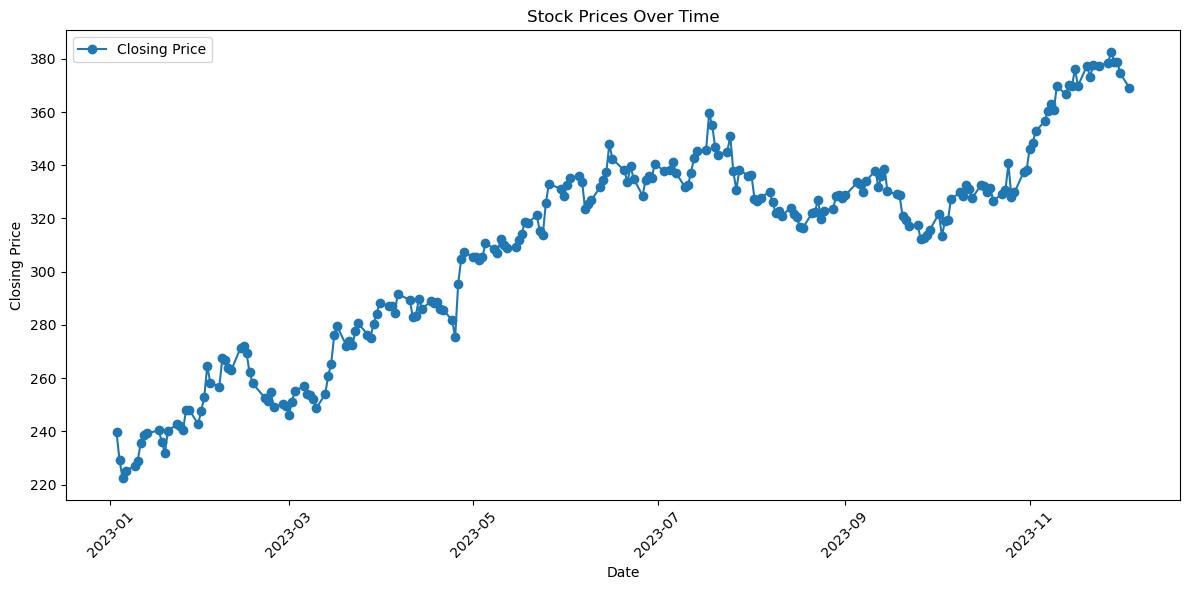

In [42]:
def fetch_data_from_cassandra():
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    rows = session.execute('SELECT * FROM eod_data')
    
    data = {
        'date': [],
        'close': []
    }

    for row in rows:
        # Convert Date type to string, then convert to datetime object
        date_obj = datetime.strptime(str(row.date), '%Y-%m-%d').date()
        data['date'].append(date_obj)
        data['close'].append(row.close)

    cluster.shutdown()
    return data

def plot_stock_prices(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['close'], label='Closing Price', marker='o')
    plt.title('Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Fetch data from Cassandra and plot
cassandra_data = fetch_data_from_cassandra()
plot_stock_prices(cassandra_data)


In [50]:
def fetch_data_from_cassandra():
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    rows = session.execute('SELECT * FROM eod_data')
    
    data = {
        'date': [],
        'symbol': [],
        'close': []
    }

    for row in rows:
        # Convert Date type to string, then convert to datetime object
        date_obj = datetime.strptime(str(row.date), '%Y-%m-%d').date()
        data['date'].append(date_obj)
        data['symbol'].append(row.symbol)
        data['close'].append(row.close)

    cluster.shutdown()
    return pd.DataFrame(data)

def calculate_returns(df):
    df_pivot = df.pivot(index='date', columns='symbol', values='close')
    returns_df = df_pivot.pct_change().dropna()  # Calculate daily returns
    return returns_df

def calculate_variance(df, selection_count):
    covariance_matrix = df.cov()
    mean_vector = df.mean()

    inverse_covariance_matrix = np.linalg.inv(covariance_matrix)

    one_vector = np.ones(selection_count) / selection_count

    value = one_vector @ inverse_covariance_matrix @ one_vector.T

    mvp_weights = (1 / value) * inverse_covariance_matrix @ one_vector
    expected_return = mvp_weights @ mean_vector
    variance = mvp_weights.T @ covariance_matrix @ mvp_weights

    return variance, expected_return, mvp_weights

def find_optimal_combination(df, optimize_for="variance", selection_count=5):
    best_variance = float('inf')
    best_return = 0
    best_combo = []
    best_weights = []

    for combo in itertools.combinations(df.columns, selection_count):
        combo_df = df[list(combo)]
        (combo_variance, combo_return, weights) = calculate_variance(combo_df, selection_count)

        if optimize_for == "variance" and combo_variance < best_variance:
            best_variance = combo_variance
            best_combo = list(combo)
            best_return = combo_return
            best_weights = weights
        elif optimize_for == "expected return" and combo_return > best_return:
            best_variance = combo_variance
            best_combo = list(combo)
            best_return = combo_return
            best_weights = weights

    return best_combo, best_weights, best_variance, best_return


# Fetch data from Cassandra
cassandra_data = fetch_data_from_cassandra()

# Calculate returns
returns_data = calculate_returns(cassandra_data)

# Settings
optimize_for = "variance"  # Can be either "variance" or "expected return"
selection_count = 5  # Must be less than, or equal to the number of columns in the provided file

# Calculation
(best_combo, best_weights, best_variance, best_return) = find_optimal_combination(
    df=returns_data, optimize_for=optimize_for, selection_count=selection_count
)

# Printing results
print(
    f'The best combination: {best_combo}, with weights {best_weights}, had a variance of {best_variance} and a return of {best_return}'
)

The best combination: [], with weights [], had a variance of inf and a return of 0
